In [1]:
%matplotlib notebook

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import scipy as sp
from scipy import sparse

import sklearn
import sklearn.mixture
from sklearn.decomposition import PCA
# from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
import os

import openTSNE
from openTSNE import TSNE
from openTSNE import affinity, initialization, TSNEEmbedding

import time

import pickle

from scipy.stats import gaussian_kde

from sklearn.neighbors import NearestNeighbors

import umap
import numba
import pynndescent 

import memory_profiler
%load_ext memory_profiler

In this notebook we compare the default t-SNE implementation with the uniform affinities approximation.

# Import data

In [2]:
# svd transformed data
svd_data=np.load("variables/svd_data.npy")

As the default implementation cannot be run for the full dataset because of memory requirements, we randomly sample a subset of the data of $n=2$M.

In [1]:
np.random.seed(42)
subset_size=2000000
indeces_subset_2M = np.random.choice(svd_data.shape[0], size=subset_size, replace=False)

In [6]:
# save indeces
np.save("/variables/indeces_subset_2M",indeces_subset_2M)

## Default t-SNE perplexity=30

In [4]:
%%time
%%memit

tsne = TSNE(
    perplexity=30,
    metric="euclidean",
    n_jobs=-1,
    random_state=42,
    exaggeration=1,
    verbose=1,
    n_iter=2000
)

opentsne_results=tsne.fit(svd_data[indeces_subset_2M])

default_tsne_p_30=np.array(opentsne_results)

#save results
np.save("variables/subset_2M/default_tsne_p_30", default_tsne_p_30)

--------------------------------------------------------------------------------
TSNE(exaggeration=1, n_iter=2000, n_jobs=-1, random_state=42, verbose=1)
--------------------------------------------------------------------------------
===> Finding 90 nearest neighbors using Annoy approximate search using euclidean distance...
   --> Time elapsed: 530.15 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 157.84 seconds
===> Calculating PCA-based initialization...
   --> Time elapsed: 33.09 seconds
===> Running optimization with exaggeration=12.00, lr=166666.75 for 250 iterations...
Iteration   50, KL divergence 10.5531, 50 iterations in 42.0663 sec
Iteration  100, KL divergence 10.3910, 50 iterations in 42.1025 sec
Iteration  150, KL divergence 10.0354, 50 iterations in 42.4365 sec
Iteration  200, KL divergence 9.8879, 50 iterations in 42.7011 sec
Iteration  250, KL divergence 9.8685, 50 iterations in 42.2757 sec
   --> Time elapsed: 211.58 seconds
===> Running optimizatio

## Uniform affinities approximation, k=10, exgg=1

In [9]:
%%time
%%memit

A = affinity.Uniform(svd_data[indeces_subset_2M], k_neighbors=10, n_jobs=-1, verbose=1, random_state=42)

===> Finding 10 nearest neighbors using Annoy approximate search using euclidean distance...
   --> Time elapsed: 698.25 seconds
peak memory: 77995.02 MiB, increment: 6948.75 MiB
CPU times: user 1h 5min 45s, sys: 7min 53s, total: 1h 13min 39s
Wall time: 12min


In [6]:
Zs = []
kls = []
n_iter = []

def mycallback(iteration, error, embedding):
    Zs.append(embedding.copy())
    kls.append(error)
    n_iter.append(iteration)

In [7]:
%%time
%%memit

#mio bueno

I = initialization.pca(svd_data[indeces_subset_2M], random_state=42)

E = TSNEEmbedding(I, A, n_jobs=-1, random_state=42, verbose=True)

n = svd_data[indeces_subset_2M].shape[0]

# early exaggeration
E = E.optimize(n_iter=250, exaggeration=12, momentum=0.5, n_jobs=-1, learning_rate = n/12, verbose=True, callbacks=mycallback, callbacks_every_iters=50)

# final optimization without exaggeration
E = E.optimize(n_iter=2000, exaggeration=1, momentum=0.8, n_jobs=-1, learning_rate = n/12, verbose=True, callbacks=mycallback, callbacks_every_iters=50)

===> Running optimization with exaggeration=12.00, lr=166666.75 for 250 iterations...
Iteration   50, KL divergence 11.5809, 50 iterations in 29.5949 sec
Iteration  100, KL divergence 10.8885, 50 iterations in 29.4431 sec
Iteration  150, KL divergence 10.7312, 50 iterations in 30.4464 sec
Iteration  200, KL divergence 10.7208, 50 iterations in 31.0450 sec
Iteration  250, KL divergence 10.7190, 50 iterations in 30.2477 sec
   --> Time elapsed: 150.78 seconds
===> Running optimization with exaggeration=1.00, lr=166666.75 for 2000 iterations...
Iteration   50, KL divergence 8.8202, 50 iterations in 26.1168 sec
Iteration  100, KL divergence 8.1766, 50 iterations in 30.1106 sec
Iteration  150, KL divergence 7.8362, 50 iterations in 33.9690 sec
Iteration  200, KL divergence 7.6193, 50 iterations in 36.9060 sec
Iteration  250, KL divergence 7.4680, 50 iterations in 37.5480 sec
Iteration  300, KL divergence 7.3555, 50 iterations in 39.0964 sec
Iteration  350, KL divergence 7.2684, 50 iteration

In [26]:
UA_tsne_k_10_exgg_1=np.array(E)

#save tsne
np.save("variables/subset_2M/UA_tsne_k_10_exgg_1", UA_tsne_k_10_exgg_1)

# Plot

## Import data

In [63]:
#colors
automatic_colors=np.load("variables/new_colors.npy", allow_pickle=True)

# legend colors
pickle_in = open("variables/new_colors_legend.pkl","rb")
automatic_legend = pickle.load(pickle_in)


## Fig A5

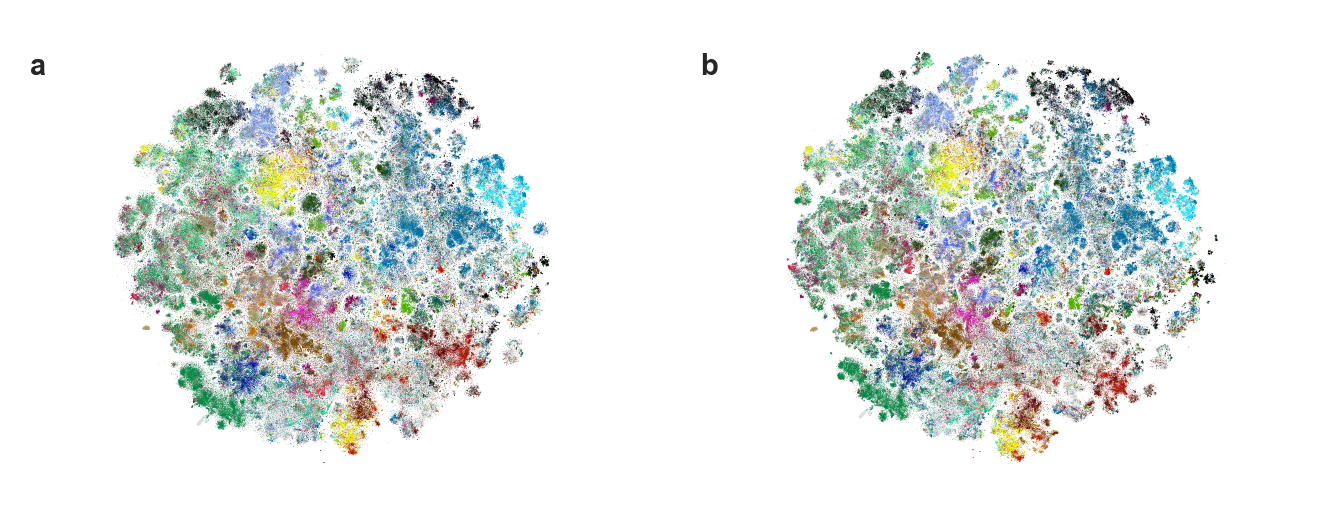

In [79]:
%matplotlib inline


# plot it
fig = plt.figure(figsize=(5.5,2), dpi=300)
gs = gridspec.GridSpec(1,2)


## default
tsne=default_tsne_p_30
colors=automatic_colors[indeces_subset_2M]
#plot
ax0 = plt.subplot(gs[:,0])
ax0.scatter(tsne[:,0][colors=='lightgrey'], tsne[:,1][colors=='lightgrey'], s=0.05,c='lightgrey', alpha=0.2, marker='.',linewidths=None,ec='None', rasterized= True)
ax0.scatter(tsne[:,0][colors!='lightgrey'], tsne[:,1][colors!='lightgrey'], s=0.07,c=colors[colors!='lightgrey'],alpha=0.7, marker='.',linewidths=None, ec='None',rasterized= True)
#extra
ax0.text(0,0.9, string.ascii_lowercase[0], transform=ax0.transAxes, size=7, weight='bold')
ax0.axis('equal')
ax0.set_axis_off()




## uniform affinities
#plot
tsne=UA_tsne_k_10_exgg_1
colors=automatic_colors[indeces_subset_2M]
#plot
ax1 = plt.subplot(gs[:,1])
ax1.scatter(tsne[:,0][colors=='lightgrey'],-tsne[:,1][colors=='lightgrey'],s=0.05,c='lightgrey', alpha=0.2, marker='.',linewidths=None,ec='None', rasterized= True)
ax1.scatter(tsne[:,0][colors!='lightgrey'],-tsne[:,1][colors!='lightgrey'],s=0.07,c=colors[colors!='lightgrey'],alpha=0.7, marker='.',linewidths=None, ec='None',rasterized= True)
#extra
ax1.text(0,0.9, string.ascii_lowercase[1], transform=ax1.transAxes, size=7, weight='bold')
ax1.axis('equal')
ax1.set_axis_off()


plt.subplots_adjust(wspace=0.1)

plt.savefig("figures/fig_A5.png", bbox_inches='tight')